In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import (get_existing_sessions, get_session_selection,
    SessionDirectory, save_optotagged_sessions, get_optotagged_sessions)
from toolkit.allen_helpers.units import OPTO_GENOTYPES
from toolkit.pipeline.units import OPTO_EVOKE_KEYS
from toolkit.pipeline.units import detect_optotag
from toolkit.plots.plots import plot_optotag_evoke_ratio, plot_optotag_units

## Config

In [2]:
session_set = 'all'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

## Get optotagging sessions

In [3]:
units_info_dfs = []
optotagged_sessions = {}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    if not session_dir.exist:
        print(f"Failed to load session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Skip loading session {session_id}: no lfp data")
    else:
        # lasers were used for opto stimulation since session 789848216
        using_laser = session_id >= 789848216

        units_info = session_dir.load_units_info()
        units_info['session_id'] = session_id
        units_info['using_laser'] = using_laser
        units_info_dfs.append(units_info)
        # check if the session is optotagged, has opto stimulation data
        genotype = units_info.iloc[0]['genotype']
        if genotype in OPTO_GENOTYPES and \
            not units_info[OPTO_EVOKE_KEYS].isna().all(axis=None):
            optotagged_sessions[session_id] = dict(using_laser=using_laser, genotype=genotype)

units_info = pd.concat(units_info_dfs)

In [4]:
if session_set == 'all':
    # Save optotagged sessions to the results directory
    optotagged_sessions_df = pd.DataFrame.from_dict(optotagged_sessions, orient='index')
    save_optotagged_sessions(optotagged_sessions_df,
        structure_acronym=ecephys_structure_acronym, session_selection=sessions_df)

# Load optotagged sessions from the results directory
optotagged_sessions_df = get_optotagged_sessions().loc[optotagged_sessions.keys()]

### Filter sessions

In [5]:
session_selection = np.ones(len(optotagged_sessions_df), dtype=bool)

# session_selection &= optotagged_sessions_df['selected']
# session_selection &= optotagged_sessions_df['using_laser']
# session_selection &= optotagged_sessions_df['session_type'] == 'functional_connectivity'

selected_sessions_df = optotagged_sessions_df.loc[session_selection]
print(f"Number of selected sessions: {len(selected_sessions_df)}")
for genotype in OPTO_GENOTYPES:
    print(f"{genotype}: {sum(selected_sessions_df['genotype'] == genotype)}")

selected_units_df = units_info.loc[units_info['session_id'].isin(selected_sessions_df.index)]
genotype_units = {}
print(f"\nNumber of selected units: {len(selected_units_df)}")
for genotype in OPTO_GENOTYPES:
    genotype_units[genotype] = selected_units_df.index[selected_units_df['genotype'] == genotype]
    print(f"{genotype}: {len(genotype_units[genotype])}")

Number of selected sessions: 19
Pvalb: 7
Sst: 12

Number of selected units: 1142
Pvalb: 347
Sst: 795


## Unit Features

In [18]:
min_rate = 1.  # Hz (minimum rate to avoid 0 firing rate)
evoked_ratio_threshold = 1.5  # threshold for ratio of evoked to baseline
ttest_alpha = 0.1  # alpha for t-test

spike_width_ranges = {'Pvalb': (0., 0.45), 'Sst': None, 'wt': None, 'RS': (0.45, np.inf)}  # ms. Spike width lower than this are PV

In [19]:
optotag_dfs = {}
for genotype in OPTO_GENOTYPES:
    optotag_dfs[genotype], _ = detect_optotag(
        selected_units_df.loc[genotype_units[genotype]],
        min_rate=min_rate, evoked_ratio_threshold=evoked_ratio_threshold,
        ttest_alpha=ttest_alpha, spike_width_range=spike_width_ranges[genotype]
    )

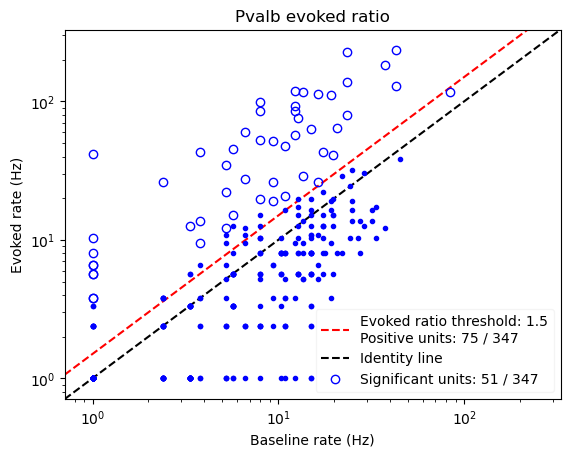

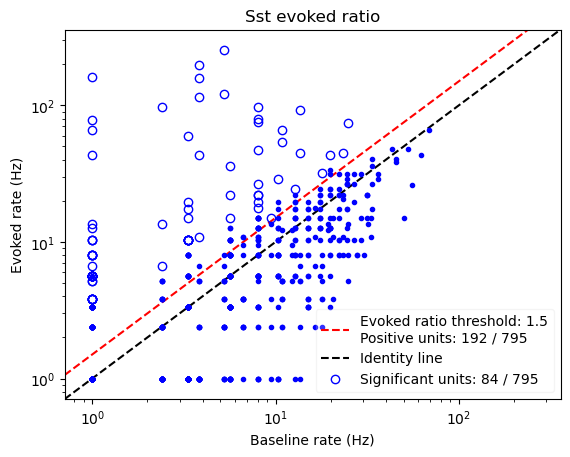

In [20]:
for genotype in OPTO_GENOTYPES:
    optotag_df = optotag_dfs[genotype]
    ax = plot_optotag_evoke_ratio(optotag_df, min_rate=min_rate, evoked_ratio_threshold=evoked_ratio_threshold)
    ax.set_title(f'{genotype} evoked ratio')

plt.show()

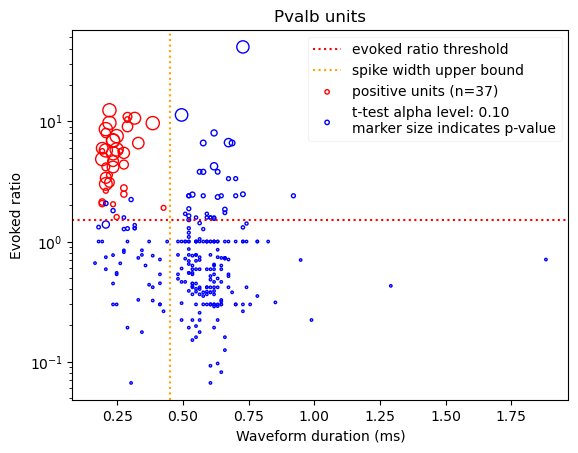

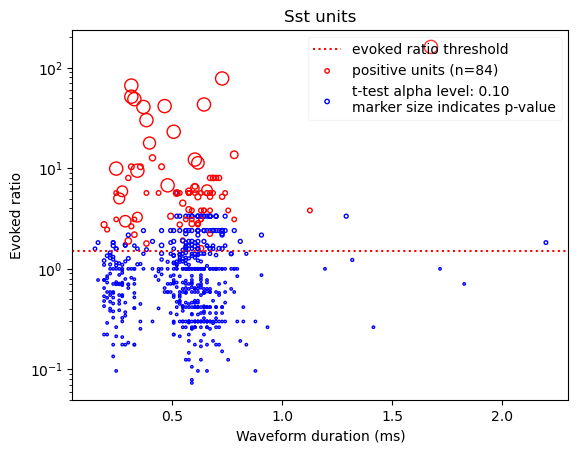

In [21]:
for genotype in OPTO_GENOTYPES:
    optotag_df = optotag_dfs[genotype]
    ax = plot_optotag_units(optotag_df, ttest_alpha=ttest_alpha,
        evoked_ratio_threshold=evoked_ratio_threshold, spike_width_range=spike_width_ranges[genotype])
    ax.set_title(f'{genotype} units')
plt.show()